In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from IPython.display import display
from scipy import stats

import warnings
%matplotlib inline 
np.random.seed(42)

### Main Goals
- Find useful information through EDA
    - Using survival analysis to speculate on important features for attrition
- Predict employee attrition
    - Target: Yes (16.0%) vs. No (84.0%)
    - Benchmark (predicting every employee as No Attrition): 84.0% accuracy
    - Metrics: Accuracy, False Negative Rate
- Predict employee quality
    - Target: Excellent Quality (84.6%) vs. Outstanding Quality (15.4%)
    - Benchmark (predicting every employee as Excellent Quality): 84.6% accuracy 
    - Metrics: Accuraccy
    - Finding feature importance
- Predict employee life-cycle
    - Target: YearsAtCompany
    - Metrics: $R^{2}$

### Findings (so far)
- Predicting employee attrition
    - 89% accuracy with XGBoost
    - We were able to find and confirm important features
- Predicting employee quality
    - Was not able to get above random guessing
- Predicting years at the company
    - $R^{2}$ = .8934 using RandomforestRegressor
    - Important features for lifecycle
    
### Further work
- Implement model stacking, more visuals, and possibly deploy a web app
    - Would also like to come up with a function that calculates the expected cost for churn (maybe $P(\text{Churn}) \cdot \text{cost}$)

### Loading the dataset
- IBM's HR Analytics Employee Attrition and Performance
    - https://www.kaggle.com/pavansubhasht/ibm-hr-analytics-attrition-dataset
    - Fictional dataset created by IBM Data Scientists
- 1470 Observations
- 35 Features

In [2]:
hr_df = pd.read_csv('ibm_hr.csv')

In [3]:
hr_df.head() # 35 columns

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [4]:
hr_df.shape

(1470, 35)

### No Missing Values
- Everything appears to be the right data type
- Will have to manually change some of the numeric columns to categorical

In [5]:
hr_df.info() # no missing values, everything appears to be the right data type

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
Age                         1470 non-null int64
Attrition                   1470 non-null object
BusinessTravel              1470 non-null object
DailyRate                   1470 non-null int64
Department                  1470 non-null object
DistanceFromHome            1470 non-null int64
Education                   1470 non-null int64
EducationField              1470 non-null object
EmployeeCount               1470 non-null int64
EmployeeNumber              1470 non-null int64
EnvironmentSatisfaction     1470 non-null int64
Gender                      1470 non-null object
HourlyRate                  1470 non-null int64
JobInvolvement              1470 non-null int64
JobLevel                    1470 non-null int64
JobRole                     1470 non-null object
JobSatisfaction             1470 non-null int64
MaritalStatus               1470 non-null object
MonthlyIncome         

### Changing some numerical data to categorical
- Education: 1 = 'Below College', 2 = 'College', 3 = 'Bachelor', 4 = 'Master', 5 = 'Doctor'
- EnvironmentSatisfaction: 1 = 'Low', 2 = 'Medium', 3 = 'High', 4 = 'Very High'
- JobInvolvement: 1 = 'Low', 2 = 'Medium', 3 = 'High', 4 = 'Very High'
- JobSatisfaction: 1 = 'Low', 2 = 'Medium', 3 = 'High', 4 = 'Very High'
- PerformanceRating: 1 = 'Low', 2 = 'Good', 3 = 'Excellent', 4 'Outstanding'
- RelationshipSatisfaction: 1 = 'Low', 2 = 'Medium', 3 = 'High', 4 = 'Very High'
- WorkLifeBalance: 1 = 'Bad', 2 = 'Good', 3 = 'Better', 4 = 'Best'

In [6]:
# Changing numeric values to corresponding categorical values
hr_df['Education'] = hr_df['Education'].map({1: 'Below College', 2: 'College', 3: 'Bachelor', 4: 'Masters', 5: 'Doctor'})
hr_df['EnvironmentSatisfaction'] = hr_df['EnvironmentSatisfaction'].map({1: 'Low', 2: 'Medium', 3: 'High', 4: 'Very High'})
hr_df['JobInvolvement'] = hr_df['JobInvolvement'].map({1: 'Low', 2: 'Medium', 3: 'High', 4: 'Very High'})
hr_df['JobSatisfaction'] = hr_df['JobSatisfaction'].map({1: 'Low', 2: 'Medium', 3: 'High', 4: 'Very High'})
hr_df['RelationshipSatisfaction'] = hr_df['RelationshipSatisfaction'].map({1: 'Low', 2: 'Medium', 3: 'High', 4: 'Very High'})
hr_df['PerformanceRating'] = hr_df['PerformanceRating'].map({1: 'Low', 2: 'Good', 3: 'Excellent', 4: 'Outstanding'})
hr_df['WorkLifeBalance'] = hr_df['WorkLifeBalance'].map({1: 'Bad', 2: 'Good', 3: 'Better', 4: 'Best'})

In [7]:
hr_categorical = []
hr_numerical = []
for column in hr_df:
    if type(hr_df[column][1]) == str:
        hr_categorical.append(column)
    
    else:
        hr_numerical.append(column)
        

In [8]:
len(hr_categorical) #9 categorical columns
len(hr_numerical) #26 numerical columns

19

In [9]:
numerical_df = hr_df[hr_numerical]
categorical_df = hr_df[hr_categorical]

In [10]:
numerical_df.head()

,Age,DailyRate,DistanceFromHome,EmployeeCount,EmployeeNumber,HourlyRate,JobLevel,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,1102,1,1,1,94,2,5993,19479,8,11,80,0,8,0,6,4,0,5
1,49,279,8,1,2,61,2,5130,24907,1,23,80,1,10,3,10,7,1,7
2,37,1373,2,1,4,92,1,2090,2396,6,15,80,0,7,3,0,0,0,0
3,33,1392,3,1,5,56,1,2909,23159,1,11,80,0,8,3,8,7,3,0
4,27,591,2,1,7,40,1,3468,16632,9,12,80,1,6,3,2,2,2,2


### Might consider some feature engineering (i.e. chaning monthly income into categorical)

In [11]:
categorical_df.head()

,Attrition,BusinessTravel,Department,Education,EducationField,EnvironmentSatisfaction,Gender,JobInvolvement,JobRole,JobSatisfaction,MaritalStatus,Over18,OverTime,PerformanceRating,RelationshipSatisfaction,WorkLifeBalance
0,Yes,Travel_Rarely,Sales,College,Life Sciences,Medium,Female,High,Sales Executive,Very High,Single,Y,Yes,Excellent,Low,Bad
1,No,Travel_Frequently,Research & Development,Below College,Life Sciences,High,Male,Medium,Research Scientist,Medium,Married,Y,No,Outstanding,Very High,Better
2,Yes,Travel_Rarely,Research & Development,College,Other,Very High,Male,Medium,Laboratory Technician,High,Single,Y,Yes,Excellent,Medium,Better
3,No,Travel_Frequently,Research & Development,Masters,Life Sciences,Very High,Female,High,Research Scientist,High,Married,Y,Yes,Excellent,High,Better
4,No,Travel_Rarely,Research & Development,Below College,Medical,Low,Male,High,Laboratory Technician,Medium,Married,Y,No,Excellent,Very High,Better


In [12]:
categorical_df['Attrition'] = categorical_df['Attrition'].map({'Yes': 1, 'No': 0})

C:\Users\Edward\Anaconda2\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [13]:
hr_df['Attrition'] = hr_df['Attrition'].map({'Yes': 1, 'No': 0})

### EDA

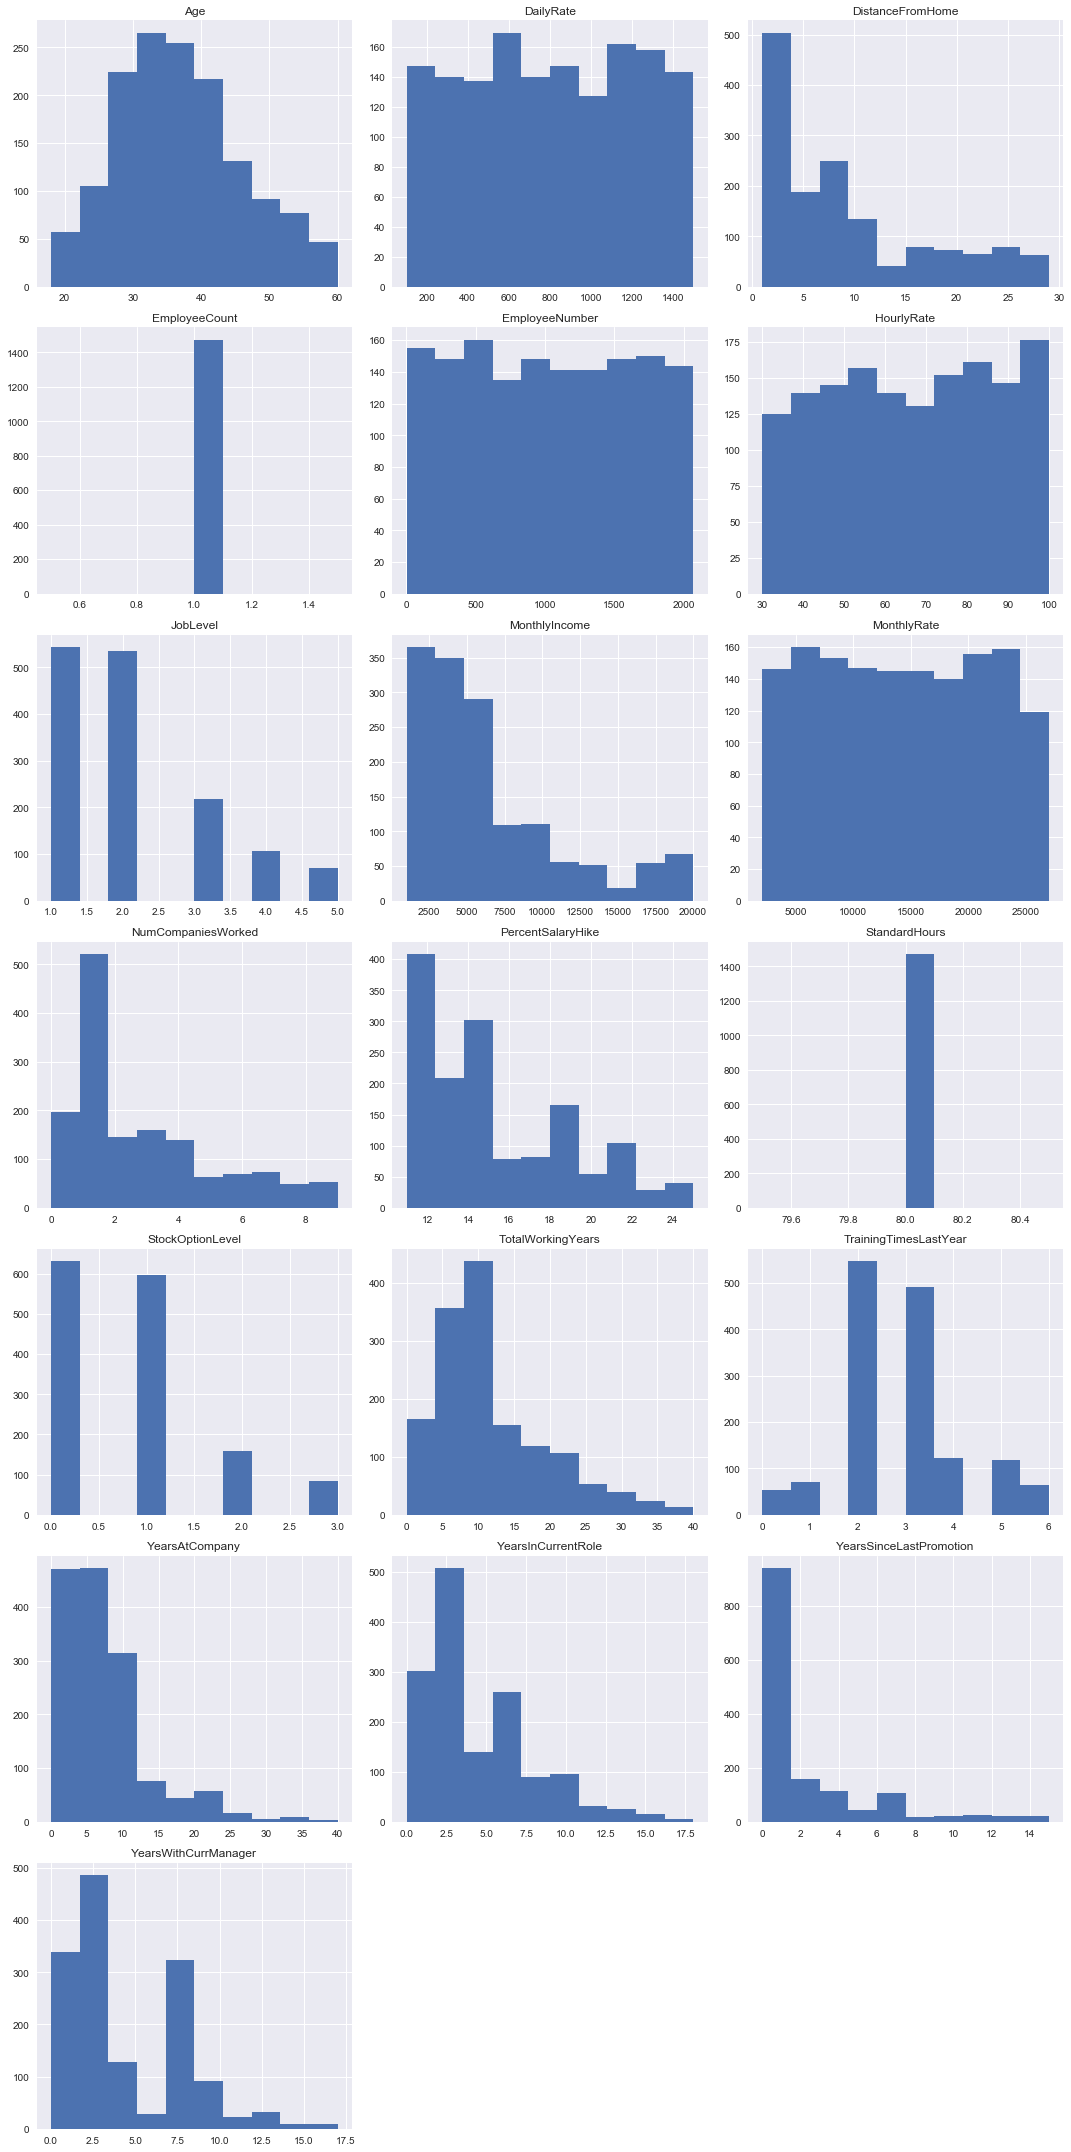

In [14]:
# histograms of the numerical data
fig = plt.figure(figsize = (15,30))
i = 0

for column in numerical_df:
    i += 1
    fig.add_subplot(7,3,i)
    plt.hist(numerical_df[column])
    plt.title(column)
plt.tight_layout()

### Some observations
- EmployeeCount and StandardHours are the same for every observation, plus no insights from EmployeeNumber $\Rightarrow$ drop em'
- A lot of the features are skewed right
- A lot of features have outliers

In [16]:
hr_df = hr_df.drop(['EmployeeCount', 'StandardHours', 'EmployeeNumber'], axis = 1)

In [17]:
numerical_df = numerical_df.drop(['EmployeeCount', 'StandardHours', 'EmployeeNumber'], axis = 1)

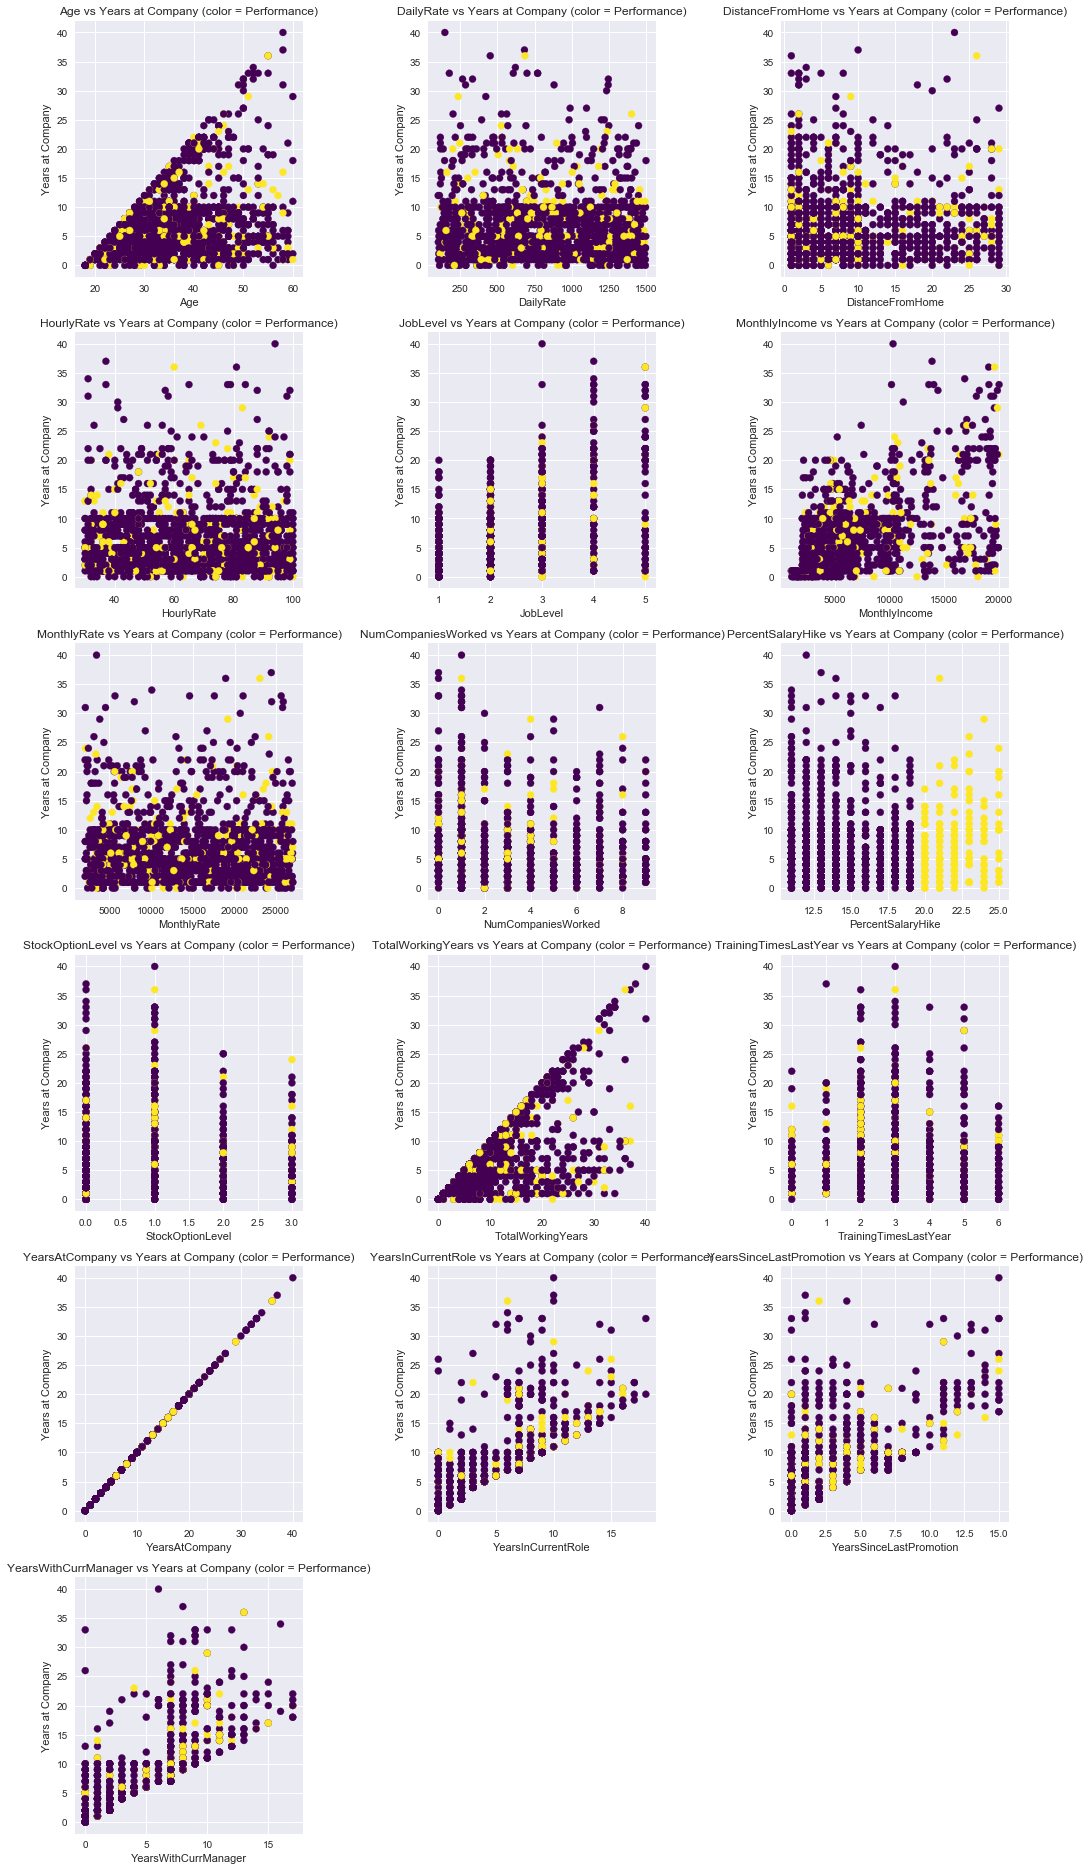

In [18]:
fig = plt.figure(figsize = (15,30))
i = 0

for col in numerical_df:
    i += 1
    fig.add_subplot(7,3,i)
    plt.scatter(numerical_df[col], numerical_df['YearsAtCompany'],
                c = pd.Categorical(categorical_df['PerformanceRating']).codes, cmap = 'viridis')
    plt.title(col + " vs Years at Company (color = Performance)")
    plt.xlabel(col)
    plt.ylabel('Years at Company')

plt.tight_layout()

### We see that there is a perfect split in the data for PercentSalaryHike vs Performance
- We will drop this when trying to predict Performance

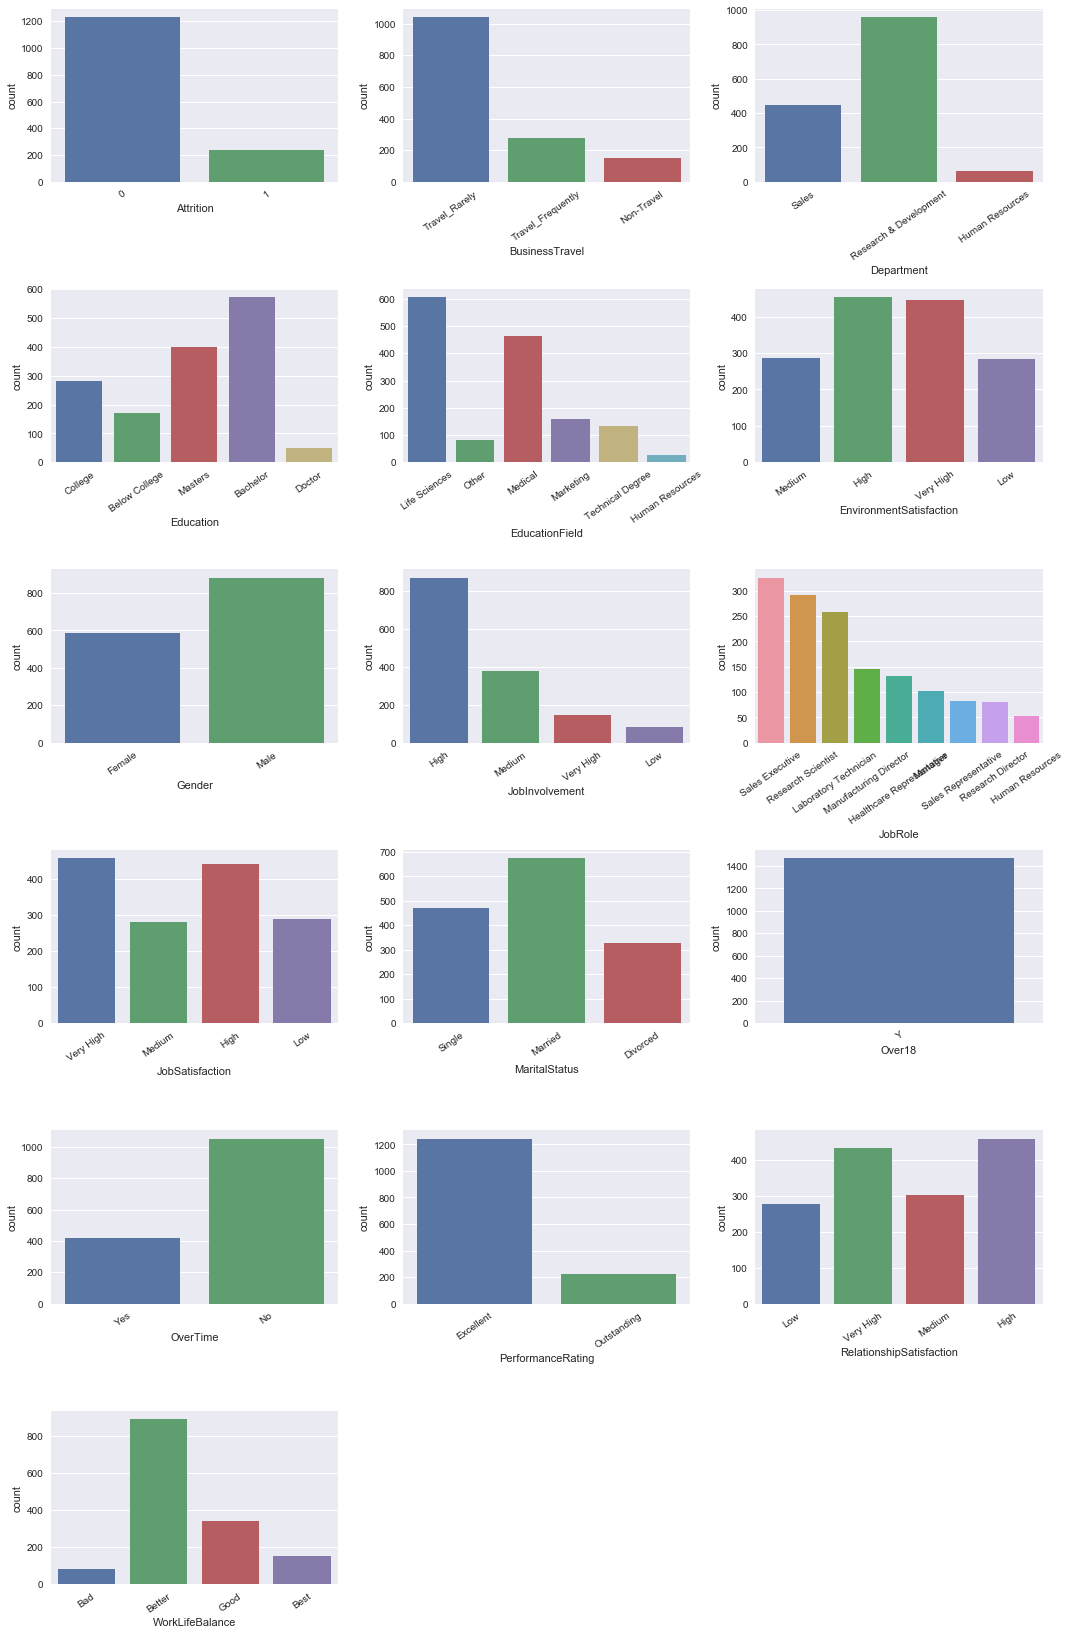

In [15]:
fig = plt.figure(figsize = (15,30))
i = 0

for col in categorical_df:
    i += 1
    fig.add_subplot(8,3,i)
    sns.countplot(categorical_df[col])
    plt.xticks(rotation=35)
    #plt.title(col)
    
plt.tight_layout()

### Insights
- Class inbalances in Attrition and Performance Rating
    - Only two classes of empolyees, excellent and outstanding
- We can drop the over 18 column

In [20]:
categorical_df = categorical_df.drop('Over18', axis = 1)

In [197]:
categorical_df['PerformanceRating'].value_counts() #84.6% level 3 performers, 15.4% level 4 performers => benchmark of 84.6% accuracy

Excellent     1244
Oustanding     226
Name: PerformanceRating, dtype: int64

In [21]:
cor = numerical_df.corr()

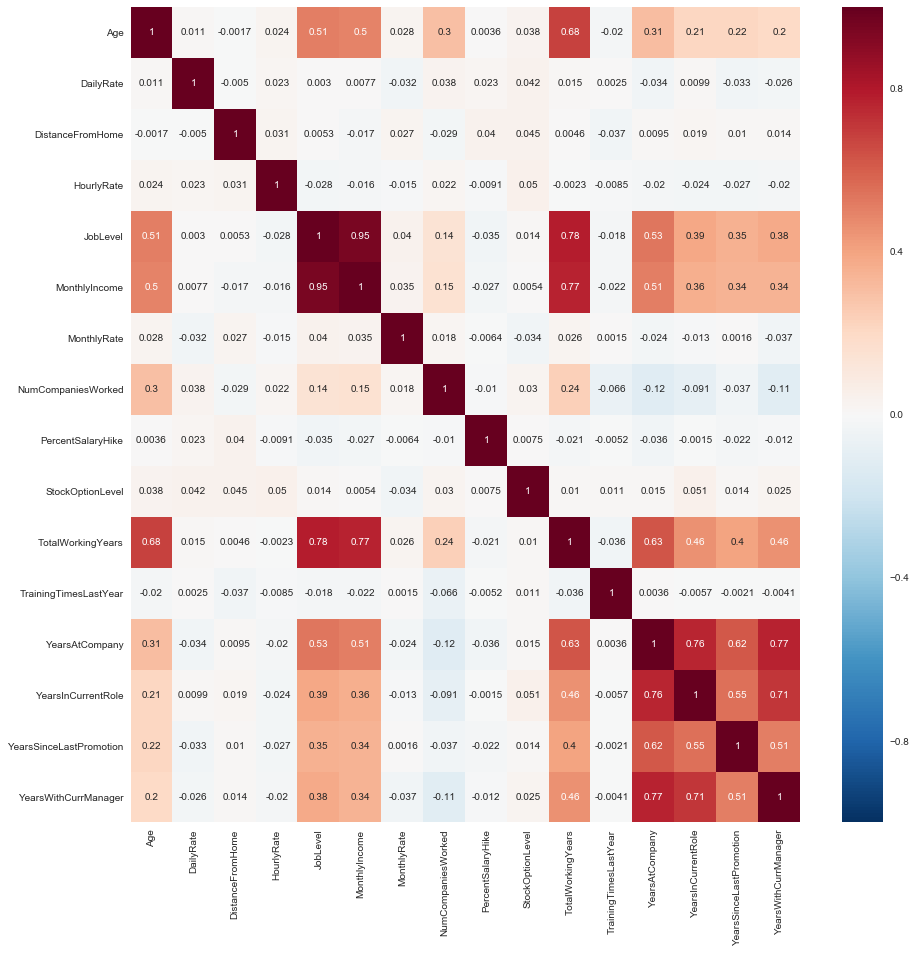

In [22]:
plt.figure(figsize = (15,15))
sns.heatmap(cor, annot = True)

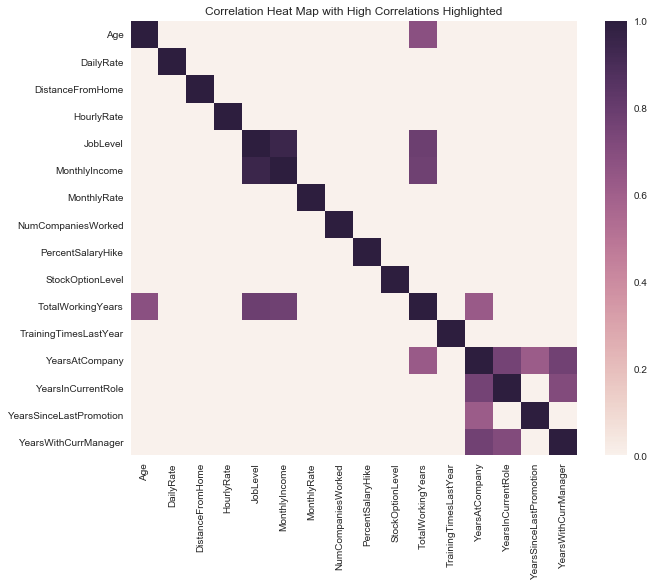

In [23]:
plt.figure(figsize = (10,8))
big_cor = cor.where(abs(cor) > .6)
sns.heatmap(big_cor.replace(np.nan, 0))
plt.title('Correlation Heat Map with High Correlations Highlighted')

### Insights
- There are some redundant features, but not a whole lot of high correlations across the board

In [24]:
hr_df = pd.concat([categorical_df, numerical_df], axis = 1)
pd.to_pickle(hr_df, 'hr_df.p')